使用设备: cuda
loading annotations into memory...
Done (t=11.87s)
creating index...
index created!
筛选出 3252 张包含单车的图片
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
筛选出 149 张包含单车的图片
最终训练集大小: 2000 张图片
每轮训练步数: 1000

===== 开始训练第 1/3 轮 =====
步骤 [50/1000] | 损失: 0.1645 | 剩余时间: 4.7 分钟
步骤 [100/1000] | 损失: 0.3677 | 剩余时间: 4.8 分钟
步骤 [150/1000] | 损失: 0.3385 | 剩余时间: 4.6 分钟
步骤 [200/1000] | 损失: 0.1263 | 剩余时间: 4.2 分钟
步骤 [250/1000] | 损失: 0.1522 | 剩余时间: 4.1 分钟
步骤 [300/1000] | 损失: 0.4223 | 剩余时间: 3.7 分钟
步骤 [350/1000] | 损失: 0.4792 | 剩余时间: 3.5 分钟
步骤 [400/1000] | 损失: 0.5595 | 剩余时间: 3.2 分钟
步骤 [450/1000] | 损失: 0.1845 | 剩余时间: 3.0 分钟
步骤 [500/1000] | 损失: 0.1895 | 剩余时间: 2.6 分钟
步骤 [550/1000] | 损失: 0.0830 | 剩余时间: 2.2 分钟
步骤 [600/1000] | 损失: 0.3020 | 剩余时间: 2.1 分钟
步骤 [650/1000] | 损失: 0.2975 | 剩余时间: 1.8 分钟
步骤 [700/1000] | 损失: 0.4787 | 剩余时间: 1.6 分钟
步骤 [750/1000] | 损失: 0.4332 | 剩余时间: 1.3 分钟
步骤 [800/1000] | 损失: 0.2474 | 剩余时间: 1.1 分钟
步骤 [850/1000] | 损失: 0.0701 | 剩余时间: 0.8 分钟
步骤 [900/1000] | 损失

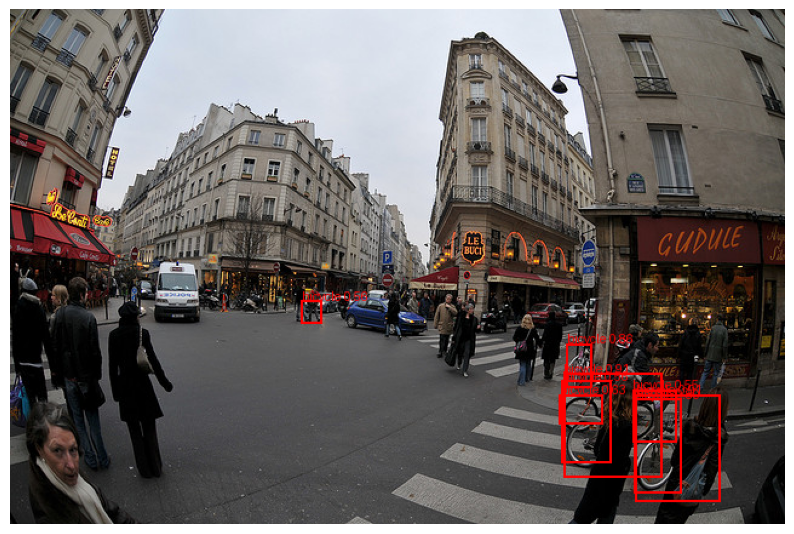

模型已保存到: /kaggle/working/bicycle_detection_model.pth


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For Kaggle COCO单车检测专用版本
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import math
import time
from statistics import mean
from PIL import ImageDraw

# -------------------------- 1. 环境与路径配置 --------------------------
# Kaggle上COCO2017的路径
DATASET_PATH = "/kaggle/input/coco-2017-dataset/coco2017"
TRAIN_IMAGES = f"{DATASET_PATH}/train2017"
VAL_IMAGES = f"{DATASET_PATH}/val2017"
TRAIN_ANN = f"{DATASET_PATH}/annotations/instances_train2017.json"
VAL_ANN = f"{DATASET_PATH}/annotations/instances_val2017.json"

# 确认设备（Kaggle上有GPU）
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"使用设备: {device}")

# -------------------------- 2. 定义仅保留单车的COCO数据集类 --------------------------
class CocoBicycleDetection(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile, transform)
        # COCO中bicycle的category_id是1
        self.bicycle_cat_id = 2
        # 筛选出仅包含单车的图片ID
        self.bicycle_img_ids = self.coco.getImgIds(catIds=[self.bicycle_cat_id])
        # 重新构建样本列表（只保留单车图片）
        self.ids = self.bicycle_img_ids
        print(f"筛选出 {len(self.ids)} 张包含单车的图片")

    def __getitem__(self, idx):
        # 加载图片和标注
        img, anns = super().__getitem__(idx)
        # 过滤标注：只保留单车的标注
        bicycle_anns = [ann for ann in anns if ann['category_id'] == self.bicycle_cat_id]
        # 确保至少有一个单车标注（避免空样本）
        if len(bicycle_anns) == 0:
            return self.__getitem__((idx + 1) % len(self))
        return img, bicycle_anns

# -------------------------- 3. 数据预处理与加载 --------------------------
# 简单的转换
transform = transforms.Compose([
    transforms.ToTensor()
])

# 加载仅包含单车的训练/验证集
train_dataset = CocoBicycleDetection(root=TRAIN_IMAGES, annFile=TRAIN_ANN, transform=transform)
val_dataset = CocoBicycleDetection(root=VAL_IMAGES, annFile=VAL_ANN, transform=transform)

# 进一步缩小训练集（Kaggle训练时间有限，可选1000-3000张）
subset_size = 2000  # 根据Kaggle算力调整，2000张训练速度快且效果足够
indices = torch.randperm(len(train_dataset))[:subset_size].tolist()
train_subset = Subset(train_dataset, indices)
print(f"最终训练集大小: {len(train_subset)} 张图片")

# 定义DataLoader（collate_fn处理不等长标注）
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_subset,
    batch_size=2,  # Kaggle GPU显存有限，batch_size=2最合适
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# 计算每轮步数
steps_per_epoch = math.ceil(len(train_subset) / train_loader.batch_size)
print(f"每轮训练步数: {steps_per_epoch}")

# -------------------------- 4. 构建仅检测单车的Faster R-CNN模型 --------------------------
def get_bicycle_detection_model():
    # 加载预训练的Faster R-CNN（ResNet50 backbone）
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # 替换分类头：仅检测1类（单车）+ 背景 = 2类
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
    
    # 冻结backbone
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    return model

# 初始化模型并移到GPU
model = get_bicycle_detection_model()
model.to(device)

# -------------------------- 5. 定义优化器和学习率调度器 --------------------------
# 只优化需要更新的参数（仅头部）
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# -------------------------- 6. 标注格式转换（COCO→Faster R-CNN） --------------------------
def coco_to_fasterrcnn_targets(anns, device):
    boxes, labels = [], []
    for obj in anns:
        x, y, w, h = obj['bbox']
        if w > 0 and h > 0:  # 过滤无效框
            # COCO bbox是[x, y, w, h] → 转换为[x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # 单车的类别ID设为1（背景是0）
    return {
        'boxes': torch.as_tensor(boxes, dtype=torch.float32, device=device),
        'labels': torch.as_tensor(labels, dtype=torch.int64, device=device)
    }

# -------------------------- 7. 训练模型 --------------------------
num_epochs = 3  
model.train()

for epoch in range(num_epochs):
    print(f"\n===== 开始训练第 {epoch+1}/{num_epochs} 轮 =====")
    step_times = []
    epoch_start = time.time()
    
    for i, (imgs, annotations) in enumerate(train_loader, 1):
        step_start = time.time()
        
        # 图片移到GPU
        imgs = [img.to(device) for img in imgs]
        # 标注转换并移到GPU
        targets = [coco_to_fasterrcnn_targets(ann, device) for ann in annotations]
        
        # 前向传播 + 计算损失
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # 反向传播 + 优化
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # 记录时间和打印进度
        step_times.append(time.time() - step_start)
        if i % 50 == 0:
            avg_step_time = mean(step_times[-50:])
            eta = (steps_per_epoch - i) * avg_step_time / 60
            print(f"步骤 [{i}/{steps_per_epoch}] | 损失: {losses.item():.4f} | 剩余时间: {eta:.1f} 分钟")
    
    # 更新学习率
    lr_scheduler.step()
    epoch_time = (time.time() - epoch_start) / 60
    print(f"第 {epoch+1} 轮训练完成，耗时: {epoch_time:.2f} 分钟")

# -------------------------- 8. 模型验证与可视化 --------------------------
model.eval()
# 取验证集第一张图片测试
val_img, val_anns = val_dataset[0]
val_img_gpu = val_img.to(device)

# 推理（无梯度计算）
with torch.no_grad():
    prediction = model([val_img_gpu])[0]

# 可视化检测结果
def visualize_detection(img, prediction, threshold=0.5):
    # 转换为PIL图片
    pil_img = transforms.ToPILImage()(img.cpu())
    draw = ImageDraw.Draw(pil_img)
    
    # 过滤置信度>0.5的检测框
    boxes = prediction['boxes'][prediction['scores'] > threshold].cpu().numpy()
    scores = prediction['scores'][prediction['scores'] > threshold].cpu().numpy()
    
    # 绘制检测框
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1-10), f"bicycle {score:.2f}", fill="red")
    
    # 显示图片
    plt.figure(figsize=(10, 8))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.show()

# 可视化结果
visualize_detection(val_img, prediction)

# -------------------------- 9. 保存训练好的模型 --------------------------
model_save_path = "/kaggle/working/bicycle_detection_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)
print(f"模型已保存到: {model_save_path}")